- Read CSV

- Filter rows by Site and Type (ISCO or grab; endmember)

- Convert Date to date format

- Select key columns

- Drop rows with NAs

- Label events by month/event

- Scale numeric data

- Run PCA

- Plot PCA results color-coded by month/event

Rows: 119 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Sample ID, Site, Date, Type, Type2, Index-notes, ICP-notes, IC-no...
dbl  (20): Fe_mg_L, Mn_mg_L, Cu_mg_L, Zn_mg_L, Si_mg_L, K_mg_L, P_mg_L, Mg_m...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


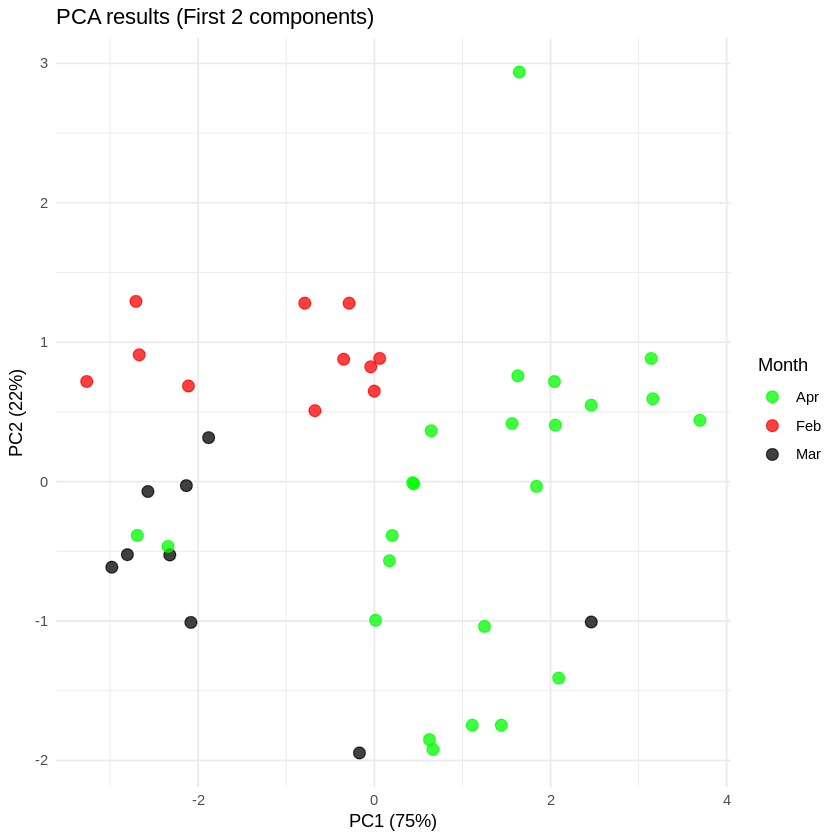

In [154]:
# Load required libraries
library(readr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(tidyr)
library(scales)

#Set working directory
setwd("/home/millieginty/OneDrive/git-repos/EMMA/")

# 1. Load the data
data <- read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# 2. Filter for Site = "Wade" and Type in allowed values
data <- data %>%
  filter(Site == "Wade", Type %in% c("Grab", "Grab/Isco", "Baseflow"))

# 3. Convert Date to Date format (coerce invalid dates to NA)
data <- data %>%
  mutate(Date = mdy(Date)) %>%
  filter(!is.na(Date))  # drop rows with unknown dates

# 4. Select relevant parameters
selected_columns <- c("Date", "Ca_mg_L", "d18O", "dD", "Na_mg_L", "Mg_mg_L")
subset_data <- data %>%
  select(all_of(selected_columns))

# 5. Drop rows with any NA values
subset_data <- subset_data %>%
  drop_na()

# 6. Label events based on month
subset_data <- subset_data %>%
  mutate(Event = case_when(
    Date >= as.Date("2023-01-01") & Date <= as.Date("2023-01-31") ~ "Jan",
    Date >= as.Date("2023-02-01") & Date <= as.Date("2023-02-28") ~ "Feb",
    Date >= as.Date("2023-03-01") & Date <= as.Date("2023-03-31") ~ "Mar",
    Date >= as.Date("2023-04-01") & Date <= as.Date("2023-04-30") ~ "Apr",
    TRUE ~ "Unknown"
  ))

# 7. Prepare data for PCA (drop Date and Event)
numeric_data <- subset_data %>%
  select(-Date, -Event)

# 8. Standardize the data
scaled_data <- scale(numeric_data)

# 9. Apply PCA
pca_result <- prcomp(scaled_data, center = TRUE, scale. = TRUE)
pca_df <- as.data.frame(pca_result$x[, 1:2])  # Keep first two components
pca_df$Event <- subset_data$Event

# 10. Plot the PCA result
ggplot(pca_df, aes(x = PC1, y = PC2, color = Event)) +
  geom_point(alpha = 0.75, size = 3) +
  scale_color_manual(values = c("Jan" = "blue", "Feb" = "red", 
                                "Mar" = "black", "Apr" = "green")) +
  labs(
    title = "PCA results (First 2 components)",
    x = paste0("PC1 (", percent(summary(pca_result)$importance[2,1]), ")"),
    y = paste0("PC2 (", percent(summary(pca_result)$importance[2,2]), ")"),
    color = "Month"
  ) +
  theme_minimal()


# Now running a full EMMA process:

- tidyverse: data wrangling and plotting

- lubridate: datetime handling

- scales: plot formatting

- stats: PCA

- quadprog or nloptr: constrained optimization for mixing model

# The python workflow used scipy.optimize.minimize() with constraints. R has similar functionality via nloptr or quadprog, though the interface is a bit different.

In [155]:
#############
# LIBRARIES #
#############

library(tidyverse)
library(lubridate)
library(scales)
library(nloptr)
library(patchwork)

##################
# RUN PARAMETERS #
##################

# Parameters
Site <- "Wade"
Month <- "February"
#Event <- "Feb ROS"

# Define Event A
start_A <- as.POSIXct("2023-02-15 00:00:00")
end_A   <- as.POSIXct("2023-02-19 00:00:00")

# Tracer set depending on Site
tracers <- if (Site == "Hungerford") {
  c("Ca_mg_L", "Cl_mg_L", "Si_mg_L", "Na_mg_L", "Mg_mg_L")
} else {
  c("Ca_mg_L", "dD", "d18O", "Na_mg_L", "Mg_mg_L")
}

# Event start-end datetimes based on Event
#start <- if (Event == 'Feb ROS") {
  #"2023-02-09 00:00:00'

################
# READ IN DATA #
################

#Set working directory
setwd("/home/millieginty/OneDrive/git-repos/EMMA/")

# Load streamwater data
data <- read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv") %>%
  filter(!is.na(Date),
        Site == 'Wade') %>%
  mutate(Date = mdy(Date),
        Datetime = paste(Date, Time))
data$Datetime <- as.POSIXct(data$Datetime, format = "%Y-%m-%d %H:%M:%S") 
  
data <- data %>% filter(Datetime >= start_A & Datetime <= end_A) 

# Load event-specific endmember data
em_file <- switch(Month,
  "February" = "data/newrnet-chemistry/RI23-endmembers-february-wade.csv",
  "March" = "data/newrnet-chemistry/RI23-endmembers-march-wade.csv",
  "April" = "data/newrnet-chemistry/RI23-endmembers-april-wade.csv"
)

# Read in snowpack data
# CoCoRaHS VT-FR-30 snow stake data ----
snowpack_data <- read_csv(file.path("/home/millieginty/OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")) %>%
   mutate(Datetime = datetime)

# Read in met data including incremental precip
met_data <- read.csv(file.path("/home/millieginty/OneDrive/git-repos/LCBP_Soils/OriginalData/met-station/wade_2020-2024_met_2024-11-08.csv")) %>%
   mutate(Datetime = ymd_hms(Timestamp))

scan_data <- read.csv(file.path("/home/millieginty/OneDrive//git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/wb_q_chem.csv")) %>%
   mutate(Dateime = ymd_hms(datetime),
         q_cms = q_cms_wb)

##########################
# CLEAN AND PREPARE DATA #
##########################

em_data <- read_csv(em_file) %>%
  filter(!is.na(Date)) %>%
  filter(!Type %in% c("Pre-event", "Groundwater Bear Pond", "Groundwater High Pond", "Soil water lysimeter wet")) %>%
  mutate(Date = mdy(Date),
        Datetime = paste(Date, Time))
em_data$Datetime <- as.POSIXct(em_data$Datetime, format = "%Y-%m-%d %H:%M:%S")
  

# Filter streamwater samples
streamwater_data <- data %>%
  filter(Site == Site, Type %in% c("Grab", "Grab/Isco", "Baseflow"))

# Identifying columns
id_cols <- c("Sample ID", "Site", "Type", "Datetime")

###########
### PCA ###
###########

# Streamwater PCA
stream_sub <- streamwater_data %>%
  select(all_of(id_cols), all_of(tracers)) %>%
  drop_na()

pca_stream <- prcomp(stream_sub %>% select(all_of(tracers)), scale. = TRUE)
pca_stream_df <- as.data.frame(pca_stream$x[, 1:2])
names(pca_stream_df) <- c("PC1", "PC2")
pca_stream_df <- bind_cols(stream_sub[id_cols], pca_stream_df)

# Endmember PCA
em_sub <- em_data %>%
  select(all_of(tracers)) %>%
  drop_na()

pca_em <- prcomp(em_sub, scale. = TRUE)
pca_em_matrix <- pca_em$x[, 1:2]  # 2D matrix of endmembers in PCA space

###########################
# END MEMBER MIXING SOLVE #
###########################

# Objective function
mix_obj <- function(Ii, xi, B) {
  xi_pred <- t(Ii) %*% B   # Transpose makes it 1×n
  sum((xi - xi_pred)^2)
}

# Gradient function
grad_f <- function(Ii, xi, B) {
  xi_pred <- t(Ii) %*% B
  diff <- as.numeric(xi_pred - xi)
  grad <- 2 * B %*% diff  # n × 2 %*% 2 × 1 = n × 1
  return(as.numeric(grad))
}

# Gradient of equality constraint (sum of fractions = 1)
grad_g_eq <- function(Ii) {
  matrix(1, nrow = 1, ncol = length(Ii))  # 1×n matrix of 1's
}

results <- lapply(1:nrow(pca_stream$x), function(i) {
  xi <- pca_stream$x[i, 1:2]
  B <- pca_em_matrix

  eval_f <- function(Ii) mix_obj(Ii, xi, B)
  eval_grad_f <- function(Ii) grad_f(Ii, xi, B)

  tryCatch({
    res <- nloptr::nloptr(
  x0 = rep(1 / nrow(B), nrow(B)),
  eval_f = eval_f,
  eval_grad_f = eval_grad_f,
  lb = rep(0, nrow(B)),
  ub = rep(1, nrow(B)),
  eval_g_eq = function(Ii) sum(Ii) - 1,
  eval_jac_g_eq = grad_g_eq,
  opts = list(algorithm = "NLOPT_LD_SLSQP", xtol_rel = 1e-8, maxeval = 500)
)
    res$solution
  }, error = function(e) {
    warning(paste("Failed on sample", i, ":", e$message))
    rep(NA, nrow(B))
  })
})

# Convert list to matrix
fractions_matrix <- do.call(rbind, results)

# Use unique endmember types as column names
endmember_names <- unique(em_data$Type)[1:ncol(fractions_matrix)]
colnames(fractions_matrix) <- endmember_names

# Bind with metadata
fractions_df <- bind_cols(pca_stream_df, as.data.frame(fractions_matrix)) %>%
  mutate(Sum_Fractions = rowSums(select(., all_of(endmember_names))))

fractions_df$Datetime <- as.POSIXct(fractions_df$Datetime)
snowpack_data$Datetime <- as.POSIXct(snowpack_data$Datetime)
scan_data$datetime <- as.POSIXct(scan_data$datetime)
met_data$Datetime <- as.POSIXct(met_data$Datetime)

Rows: 119 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Sample ID, Site, Date, Type, Type2, Index-notes, ICP-notes, IC-no...
dbl  (20): Fe_mg_L, Mn_mg_L, Cu_mg_L, Zn_mg_L, Si_mg_L, K_mg_L, P_mg_L, Mg_m...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 755 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): Date, Precip mm, 24-hr Snowfall cm, 24-hr Snowfall SWE mm, 24-hr S...
dbl  (5): ...1, Snowpack Depth cm, Snowpack SWE mm, snowpack_cm, water_year
date (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
“Removed 753 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 386483 rows containing missing values or values outside the scale range (`geom_line()`).”


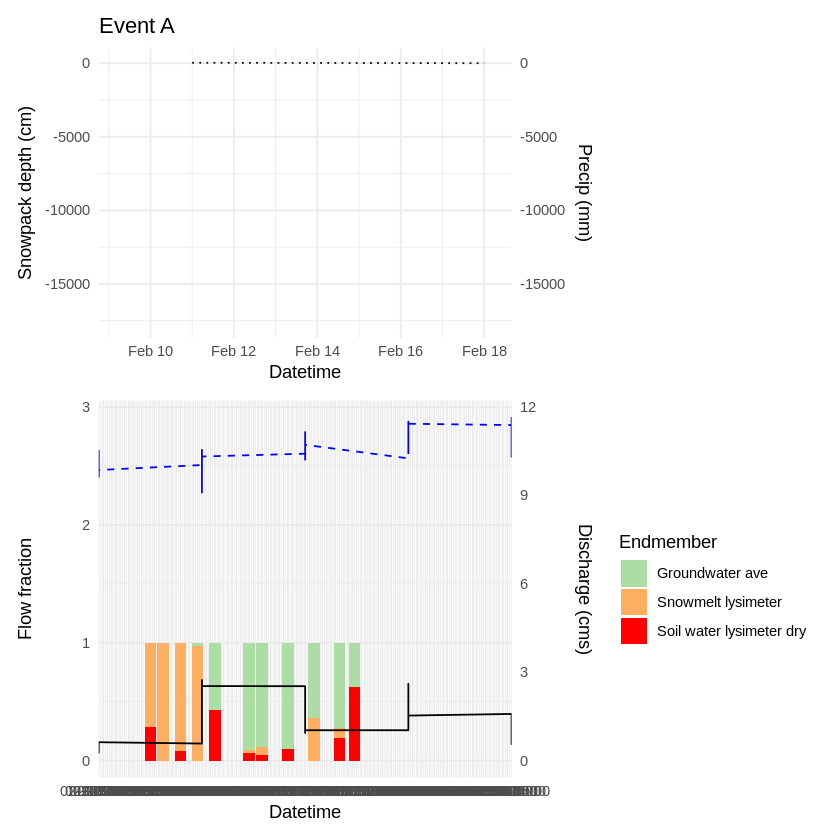

In [156]:
plot_event_emma <- function(fractions_df, colors, start, end, scan_data, snowpack_data, met_data, title = "") {
  # Prep flow fractions data
  frac_long <- fractions_df %>%
    select(Datetime, any_of(names(colors))) %>%
    pivot_longer(-Datetime, names_to = "Endmember", values_to = "Fraction")

  # Top plot: Snowpack + Rainfall
  snowpack_event <- snowpack_data %>%
    filter(Datetime >= start, Datetime <= end)

  precip_event <- met_data %>%
    filter(Datetime >= start, Datetime <= end)

  p1 <- ggplot() +
    geom_line(data = snowpack_data, aes(x = Datetime, y = snowpack_cm), color = "black", linetype = "dotted") +
    geom_line(data = met_data, aes(x = Datetime, y = Precip_Increm * 20), color = "blue") +
    scale_x_datetime(
    limits = as.POSIXct(c("2023-02-09 00:00:00", "2023-02-18 00:00:00")))  +
    scale_y_continuous(
      name = "Snowpack depth (cm)",
      sec.axis = sec_axis(~./1, name = "Precip (mm)")
    ) +
    labs(title = title) +
    theme_minimal()

  # Bottom plot: Flow fractions + discharge + nitrate
  scan_filtered <- scan_data %>%
    filter(datetime >= start, datetime <= end)

  p2 <- ggplot() +
    geom_bar(data = frac_long, aes(x = Datetime, y = Fraction, fill = Endmember), stat = "identity", position = "stack") +
    scale_fill_manual(values = colors) +
    geom_line(data = scan_filtered, aes(x = datetime, y = q_cms / 4), color = "black") +
    geom_line(data = scan_filtered, aes(x = datetime, y = NO3 / 0.1), color = "blue", linetype = "dashed") +

    # x-axis datetime scale with 1-hour breaks and 15-min formatting
  scale_x_datetime(
    breaks = scales::date_breaks("1 hour"),
    labels = scales::date_format("%m-%d %H:%M"),
    limits = c(start, end),
    expand = c(0, 0)
  ) +
    
    scale_y_continuous(
      name = "Flow fraction",
      sec.axis = sec_axis(~.*4, name = "Discharge (cms)")
    ) +
    theme_minimal()

  # Combine
  p1 / p2 + plot_layout(heights = c(1, 1.3))
}

colors_A <- c(
  'Soil water lysimeter dry'= 'red',
  'Groundwater ave'= "#abdda4",
  'Snowmelt lysimeter'= "#fdae61"
)

plot_event_emma(fractions_df, colors = colors_A,
                start = start_A, end = end_A,
                scan_data = scan_data,
                snowpack_data = snowpack_data,
                met_data = met_data,
                title = "Event A")

In [150]:
fractions_df

Sample ID,Site,Type,Datetime,PC1,PC2,Soil water lysimeter dry,Snowmelt lysimeter,Groundwater ave,Sum_Fractions
<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RI23-1009,Wade,Grab/Isco,2023-02-15 15:00:00,-4.7267269,0.1477005,0.000000e+00,1.000000e+00,5.902490e-15,1
RI23-1010,Wade,Grab/Isco,2023-02-15 19:00:00,-3.7081191,-0.1152601,2.544702e-14,1.000000e+00,0.000000e+00,1
RI23-1011,Wade,Grab/Isco,2023-02-15 23:00:00,-2.5588526,0.7520092,3.824351e-01,6.175649e-01,0.000000e+00,1
RI23-1012,Wade,Grab/Isco,2023-02-16 03:00:00,0.5560620,-0.9585616,0.000000e+00,4.584932e-01,5.415068e-01,1
RI23-1014,Wade,Grab/Isco,2023-02-16 11:00:00,1.3524328,0.2248428,3.372203e-01,1.601877e-17,6.627797e-01,1
RI23-1025,Wade,Grab,2023-02-15 12:00:00,-3.8922746,-0.6503205,5.494494e-13,1.000000e+00,0.000000e+00,1
RI23-1028,Wade,Grab/Isco,2023-02-16 14:00:00,1.5073798,-0.4220036,0.000000e+00,2.095541e-01,7.904459e-01,1
RI23-1028,Wade,Grab/Isco,2023-02-16 14:00:00,1.5073798,-0.4220036,0.000000e+00,2.095541e-01,7.904459e-01,1
RI23-1028,Wade,Grab/Isco,2023-02-16 14:00:00,1.2420356,0.3547682,3.837338e-01,0.000000e+00,6.162662e-01,1
